In [1]:
# !pip install sentence-transformers

In [2]:
import pandas as pd

import torch
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

c:\Users\kosty\anaconda3\envs\conda_3_9_11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Используем датасет с kaggle использованный для решения похожей задачи https://www.kaggle.com/code/jahysama/hey-lois-i-m-a-chatbot
data = pd.read_csv('./data/Family_guy_dialog.csv')
data.head(10)

character                                             dialog   seasons
0    Stewie   Damn you, vile woman! Youve impeded my work s...  season 1
1    Stewie                                     Hello, Mother.  season 1
2      Lois                          Well, hi, there, sweetie!  season 1
3    Stewie   You know, Mother, life is like a box of choco...  season 1
4    Stewie   Now, I offer you one last chance for deliverance  season 1
5      Lois   Oh, you just want your toy back. OK, here you...  season 1
6    Stewie   Yes, well, victory is mine! Stewie runs out o...  season 1
7    Stewie   playing with his Sesame Street phone Put me t...  season 1
8    Stewie   Dont toy with me, Ernie! Ive already dispatch...  season 1
9    Stewie   Hoho, indeed I can! pulls out a laser gun and...  season 1

In [4]:
data[['seasons']].value_counts().sort_index()

seasons  
season 1      46
season 10    168
season 12    217
season 2     129
season 3     110
season 4     155
season 5     139
season 6      94
season 7      80
season 8     117
season 9     122
Name: count, dtype: int64

In [5]:
len(data)

1377

In [6]:
data[['character']].value_counts()

character            
Peter                    394
Stewie                   269
Brian                    211
Lois                     184
Chris                    113
Meg                       85
Quagmire                  78
Cleveland                 40
Maids and Butlers M&B      3
Name: count, dtype: int64

Датасет содержит данные с 1 по 12 сезон и всего 394 целевых реплики для Питера

In [7]:
#Приводим к виду целевая реплика и 6 предшествующих
CHARACTER_NAME = 'Peter'

contexted = []

#context window size - 7
n_context = 7

for i in data[data['character'] == CHARACTER_NAME].index:
    if i < n_context:
        continue #remove if a context is less than 7 phrases

    prev = i - 1 - n_context
    row = []
    for j in range(i,prev,-1):
        row.append(data['dialog'][j])
    contexted.append(row)

columns = ['response', 'context']
columns = columns + ['context/' + str(i) for i in range(n_context-1)]

df = pd.DataFrame(contexted,columns=columns)

In [8]:
pd.set_option('display.max_colwidth', None)
df.head(5)

response   
0   after losing his Cheesy Charlies reservation Chris, this is a big day for you. Today you become the man of the house, because when we get home, your mother is going to kill me.  \
1                                                                                                          I cant even watch TV anymore. All the shows are starting to run together.   
2                                                                                                                                          Look, Chris. Its a whole family of wasps.   
3                                                                                                                    Canada sucks! Peter has a flashback of when he was on Jeopardy!   
4                                                    rings in Diarrhea. the crowd laughs What? Oh. Oh. Oh. Sorry. Sorry. What is diarrhea? after seeing the news about the heat wave   

                                                                                                                 context   
0   in his diary Day 171. Ive sprouted another finger. Counting the one from yesterday, looks at his penis, Im up to 11.  \
1                                   No, its not all right! For the love of God, shake me, shake me like a British Nanny!   
2                                                                                                         Uh, you first.   
3                                                                              Look, Chris. Its a whole family of wasps.   
4                                                        Canada sucks! Peter has a flashback of when he was on Jeopardy!   

                                                                          context/0   
0                                                  Well then, my goal becomes clear  \
1   Oh honey, I know youre hurting, but Mommy has to clean up the house, all right?   
2                                                            So, do you like music?   
3                                                                    Uh, you first.   
4                                         Look, Chris. Its a whole family of wasps.   

                                                                                                                        context/1   
0                                                                     Honey, its not gonna go away just because you dont like it.  \
1                                                                                 Very well then. I order you to kill me at once!   
2   Gosh, Id like to help you, Peter, but uh, Ive gotta go out in the hall and chew on the back of my ass for about five minutes.   
3                                                                                                          So, do you like music?   
4                                                                                                                  Uh, you first.   

                                                                                                                        context/2   
0               Very well then. ILois shoves the broccoli into his mouth. Stewie spits it out. Who the hell do you think you are?  \
1                                                             Oh, youre just teething, Stewie, its a normal part of a babys life.   
2                                                       I cant even watch TV anymore. All the shows are starting to run together.   
3   Gosh, Id like to help you, Peter, but uh, Ive gotta go out in the hall and chew on the back of my ass for about five minutes.   
4                                                                                                          So, do you like music?   

                                                                                                                                           context/3   
0                                                

In [9]:
#В "обучающей" выборке всего 394 предложения
len(df)

394

Надо сказать что результирующий датасет не на 100% чистый, помимо реплик в нем также описываются действия персонажей. Например вот здесь:
"Canada sucks! Peter has a flashback of when he was on Jeopardy!"
Но с учетом того, что задание учебное думаю их вычищать не стоит. Ведь они таже работают как контекст.

Используем следующий подход:
1) Векторизуем контекст используя предобученный трансформер
2) Используя тот-же трансформер векторизуем input
3) Используя косинусную близость будем сопостовлять input - context
4) Возвращаем соответствующий response 

In [10]:
#Преобразуем датафрейм в словарь для дальнейшего использования
def get_condext_dict (data_frame):
    context_columns = ['context'] + ['context/' + str(i) for i in range(n_context-1)]
    context_dict = {}
    for index, row in data_frame[context_columns].iterrows():

        context_val = []
        for val in row.values:
            context_val.append(val)

        context_dict[index] = context_val
    return context_dict

array([[<Axes: title={'center': '0'}>]], dtype=object)

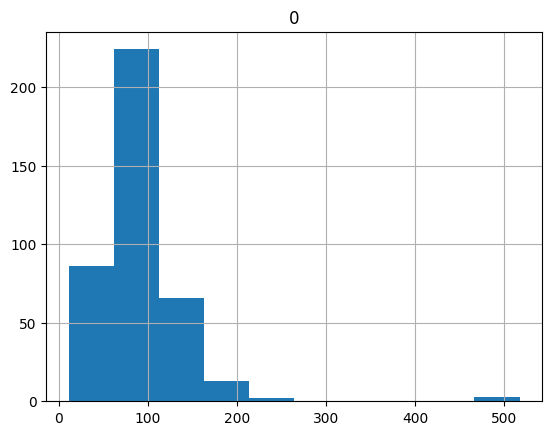

In [11]:
#Выведем гистограмму совокупной длины контекста.
context_dict = get_condext_dict (df)

sentence_len = []
for el in context_dict.values():
    single_sntence_len = 0
    for item in el:
        single_sntence_len += len(item.split())

    sentence_len.append(single_sntence_len)

pd.DataFrame(sentence_len).hist()

In [12]:
# Используем модель all-MiniLM-L6-v2 т.к. она в общем подходит для задачи сравнения предложений и нативно умеет работать со списками эмбедингов
# Load the Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [13]:
# Функция получается трививальной, но для совместимости с другими моделями оставляем ее
def get_embedding(sentences):
    embeddings = model.encode(sentences, convert_to_tensor=True, show_progress_bar=False)
    return embeddings

In [14]:
context_dict[0]

['\xa0in his diary\xa0Day 171. Ive sprouted another finger. Counting the one from yesterday,\xa0looks at his penis, Im up to 11.',
 ' Well then, my goal becomes clear',
 ' Honey, its not gonna go away just because you dont like it.',
 ' Very well then. ILois shoves the broccoli into his mouth. Stewie spits it out.\xa0Who the hell do you think you are?',
 ' My, arent we fussy tonight? OK. No broccoli.',
 ' Damn the broccoli, damn you, and damn the\xa0Wright Brothers!',
 ' Hoho, indeed I can!\xa0pulls out a laser gun and shoots the phone with each number\xa0ONE! TWO! THREE! Can I count to three? For Gods sake, Im already shooting at a fifthgrade level.Lois tries to feed Stewie his broccoli "airplane style."']

In [15]:
get_embedding(context_dict[0]).shape

torch.Size([7, 384])

In [16]:
get_embedding(context_dict[0][3:]).shape

torch.Size([4, 384])

In [17]:
%%time

context_dict = get_condext_dict (df)

# Get embeddings for contexts
context_embeddings = []
for index, context in context_dict.items():
    context_embedding = get_embedding(context)

    # Average the embeddings of sentences in the same context
    averaged_embedding = torch.mean(context_embedding, dim=0)
    context_embeddings.append(averaged_embedding)

# Stack to create a single tensor for all context embeddings
context_embeddings = torch.stack(context_embeddings)


CPU times: total: 2min 31s
Wall time: 18.9 s


In [18]:
def chat_bot(dialog_context = [],max_dialog_context_size = 6):
    
    new_user_input = input('You: ')

    # Если нужно прервать диалог, можно добавить условие выхода
    # Например, если пользователь вводит 'quit', диалог завершается
    if new_user_input.lower() == 'quit':
        return dialog_context

    dialog_context.append(new_user_input)
    
    # Ограничиваем размер контекста, если он превышает максимально допустимый
    if len(dialog_context) > max_dialog_context_size:
        dialog_context = dialog_context[-max_dialog_context_size:]
    
    input_embedding = get_embedding(dialog_context)

    # Усредняем вложения, чтобы получить одно представление контекста
    input_embedding = torch.mean(input_embedding, dim=0).unsqueeze(0)
    
    # Рассчитываем косинусное сходство между текущим контекстом и всеми возможными контекстами
    cosine_scores = cosine_similarity(input_embedding, context_embeddings)
    
    # Находим лучшее совпадение
    best_match_index = cosine_scores.argmax()
    selected_response = df.response[best_match_index]

    print(f"You:: {new_user_input}")
    print(f"Peter: {selected_response}")
    
    dialog_context.append(selected_response)

    chat_bot(dialog_context)


In [19]:
chat_bot()

[]

In [22]:
context_embeddings.shape

torch.Size([394, 384])

In [20]:
# max_dialog_context_size = 6  # Максимальный размер окна контекста
# dialog_context = []  # Инициализация пустого контекста диалога

# while True:
#     new_user_input = input('You: ')
#     dialog_context.append(new_user_input)
    
#     # Ограничиваем размер контекста, если он превышает максимально допустимый
#     if len(dialog_context) > max_dialog_context_size:
#         dialog_context = dialog_context[-max_dialog_context_size:]
    
#     input_embedding = get_embedding(dialog_context)
    
#     # Усредняем вложения, чтобы получить одно представление контекста
#     input_embedding = torch.mean(input_embedding, dim=0).unsqueeze(0)
    
#     # Рассчитываем косинусное сходство между текущим контекстом и всеми возможными контекстами
#     cosine_scores = cosine_similarity(input_embedding, context_embeddings)
    
#     # Находим лучшее совпадение
#     best_match_index = cosine_scores.argmax()
#     selected_response = df.response[best_match_index]

#     print(f"You:: {new_user_input}")
#     print(f"Peter: {selected_response}")
    
#     dialog_context.append(selected_response)
    
#     # Если нужно прервать диалог, можно добавить условие выхода
#     # Например, если пользователь вводит 'quit', диалог завершается
#     if new_user_input.lower() == 'quit':
#         break